In [8]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
from scipy import stats
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV

educ_center                                                        0
harass5_Does not apply (i do not have a job/superior/co-worker)    0
harass5_No                                                         0
harass5_Yes                                                        0
harass5_unknown                                                    0
polviews_Conservative                                              0
polviews_Extremely liberal                                         0
polviews_Extrmly conservative                                      0
polviews_Liberal                                                   0
polviews_Moderate                                                  0
polviews_Slghtly conservative                                      0
polviews_Slightly liberal                                          0
polviews_unknown                                                   0
advfront_Agree                                                     0
advfront_Disagree                 

/tmp/ipykernel_218906/223646724.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


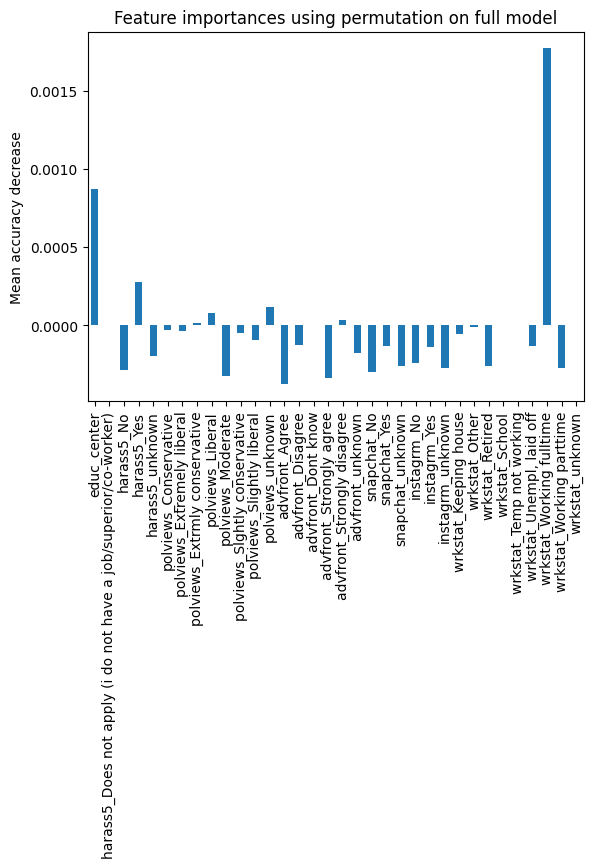

In [9]:

X = pd.read_csv("data/preprocessing/X_fill.csv")
y = pd.read_csv("data/preprocessing/y.csv")["email_time_center"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.isna().sum())

result_df = pd.DataFrame()

feature_names = list(X_train.columns)
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train)

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2,
    scoring=make_scorer(mean_squared_error, greater_is_better=False)
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

# Vẽ biểu đồ với cột tìm được.
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


In [10]:
# Thực hiện tìm tham số phù hợp.
# Thử xây dựng mô hình RandomForest với 5 feature có ảnh hưởng đến mô hình.
def tune_hyperparams(X_train, y_train, seed: int):
    distributions = dict(
        n_estimators=[128, 256, 512],
        max_depth=[2, 3, 4, 5],

    )
    forest = RandomForestRegressor(random_state=seed)
    clf = GridSearchCV(forest, distributions, 
                       scoring=make_scorer(mean_squared_error, greater_is_better=False))
    search = clf.fit(X_train, y_train)
    print(f"Best params: {search.best_params_}")
    print(f"Best score: {search.best_score_}")
    return search

top_feature_choice = [
    "wrkstat_Working fulltime",
    "polviews_Conservative",
    "educ_center",
    "polviews_Slightly liberal",
    "polviews_Moderate",
    "polviews_unknown"
]


for i in range(1, len(top_feature_choice)):
    X_top_feature = X[top_feature_choice[:i]]
    X_train, X_test, y_train, y_test = train_test_split(X_top_feature, y, random_state=42)
    print(f"Feature: {top_feature_choice[:i]}")
    tune_hyperparams(X_train, y_train, i)

# Nhận xét: Chọn 2 feature đầu là hợp lý nhất.

Feature: ['wrkstat_Working fulltime']
Best params: {'max_depth': 2, 'n_estimators': 256}
Best score: -0.01180161917798789
Feature: ['wrkstat_Working fulltime', 'polviews_Conservative']
Best params: {'max_depth': 2, 'n_estimators': 512}
Best score: -0.011818166496460381
Feature: ['wrkstat_Working fulltime', 'polviews_Conservative', 'educ_center']
Best params: {'max_depth': 2, 'n_estimators': 512}
Best score: -0.011414268241176941
Feature: ['wrkstat_Working fulltime', 'polviews_Conservative', 'educ_center', 'polviews_Slightly liberal']
Best params: {'max_depth': 2, 'n_estimators': 128}
Best score: -0.011403313517492426
Feature: ['wrkstat_Working fulltime', 'polviews_Conservative', 'educ_center', 'polviews_Slightly liberal', 'polviews_Moderate']
Best params: {'max_depth': 2, 'n_estimators': 512}
Best score: -0.011412274814043987


In [17]:
from sklearn.metrics import r2_score

y_pred = None

# Build mô hình cuối cùng, test và in kết quả.
def final_model(X_train, y_train, X_test, y_test, seed: int):
    global y_pred
    forest = RandomForestRegressor(random_state=seed, max_depth=2, n_estimators=512)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"Test MSE: {mse}")
    print(f"Test RMSE: {rmse}")
    print(f'Test R2 score: {r2}')

feature_choice = [
    'wrkstat_Working fulltime', 'polviews_Conservative', 'educ_center'
]
X = X[feature_choice]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(f"Feature: {feature_choice}")
final_model(X_train, y_train, X_test, y_test, 0)

Feature: ['wrkstat_Working fulltime', 'polviews_Conservative', 'educ_center']
Test MSE: 0.008511657766909363
Test RMSE: 0.09225864602794344
Test R2 score: 0.1058609483534052


array([[<Axes: title={'center': '0'}>]], dtype=object)

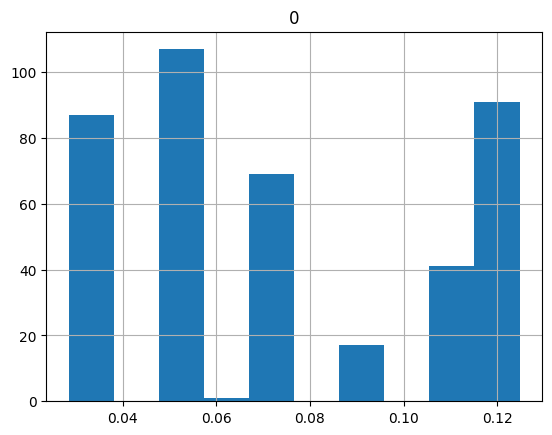

In [22]:
pd.DataFrame(y_pred).hist()